In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
import warnings

warnings.filterwarnings("ignore")

random.seed(42)

## Load dataset

In [57]:
dataset_path = 'Dataset/Dry_Bean_Dataset.csv'
df = pd.read_csv(dataset_path)

In [58]:
def encode_labels(df):
    df_copy = df.copy()
    
    def encode_label(bean_class):
        bean_type_labelings = {'BARBUNYA': 0, 'BOMBAY': 1, 'CALI': 2, 'DERMASON': 3, 'HOROZ': 4, 'SEKER': 5, 'SIRA': 6}
        return bean_type_labelings[bean_class]

    df_copy['Class'] = df_copy['Class'].apply(encode_label)
    
    return df_copy

In [59]:
df = encode_labels(df)

In [60]:
def get_samples_and_labels(df):
    y = list(df['Class']) # We extract the label for each sample
    
    X = []
    for i in range(len(y)):
        X.append(list(df.loc[i].values[:-1])) # We take all row values except for the class value (label)
    
    return X, y 

In [61]:
X, y = get_samples_and_labels(df)

## Outliers removal

In [62]:
def remove_outliers(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(df[df['Class'] == 1].index) # Drop all rows that have 'Class' = 1
    y_df_copy = list(df_copy['Class'])
    df_copy = df_copy.drop(['Class'], axis=1)

    # Calculate mean and standard deviation for each feature
    means = df_copy.mean()
    stds = df_copy.std()

    # Compute Z-scores
    z_scores = (df_copy - means) / stds

    # Identify outliers based on a threshold (e.g., 3 standard deviations away)
    threshold = 3
    outliers = z_scores[(z_scores.abs() > threshold).any(axis=1)]
    outliers_y = np.asarray(y_df_copy)[(z_scores.abs() > threshold).any(axis=1)]
    
    outliers_indices = list(outliers.index)
    return outliers_indices

In [63]:
outliers_indices = remove_outliers(df)

In [64]:
X_cleaned = [X[i] for i in range(len(X)) if i not in outliers_indices]
y_cleaned = [y[i] for i in range(len(y)) if i not in outliers_indices]

In [65]:
# We shuffle our beans, so that our train, validation, and test data will contain similar beans

zipped_X_y_cleaned = list(zip(X_cleaned, y_cleaned))
random.shuffle(zipped_X_y_cleaned)
X_cleaned, y_cleaned = zip(*zipped_X_y_cleaned)

## Train-Val-Test split

In [66]:
def separate_beans(X, y):
    barbunya, bombay, cali, dermason, horoz, seker, sira = [], [], [], [], [], [], []
    barbunya_y, bombay_y, cali_y, dermason_y, horoz_y, seker_y, sira_y = [], [], [], [], [], [], []

    for i in range(len(X)):
        if y[i] == 0:
            barbunya.append(X[i])
            barbunya_y.append(0)
        elif y[i] == 1:
            bombay.append(X[i])
            bombay_y.append(1)
        elif y[i] == 2:
            cali.append(X[i])
            cali_y.append(2)
        elif y[i] == 3:
            dermason.append(X[i])
            dermason_y.append(3)
        elif y[i] == 4:
            horoz.append(X[i])
            horoz_y.append(4)
        elif y[i] == 5:
            seker.append(X[i])
            seker_y.append(5)
        else:
            sira.append(X[i])
            sira_y.append(6)

    all_beans = []
    all_beans.append(barbunya)
    all_beans.append(bombay)
    all_beans.append(cali)
    all_beans.append(dermason)
    all_beans.append(horoz)
    all_beans.append(seker)
    all_beans.append(sira)

    all_beans_y = []
    all_beans_y.append(barbunya_y)
    all_beans_y.append(bombay_y)
    all_beans_y.append(cali_y)
    all_beans_y.append(dermason_y)
    all_beans_y.append(horoz_y)
    all_beans_y.append(seker_y)
    all_beans_y.append(sira_y)
    
    return all_beans, all_beans_y

In [67]:
all_beans, all_beans_y = separate_beans(X_cleaned, y_cleaned)

In [68]:
def split_data(all_beans, all_beans_y, train_ratio_=0.7, val_ratio_=0.15, test_ratio_=0.15):
    train_ratio, val_ratio, test_ratio = train_ratio_, val_ratio_, test_ratio_
    
    beans_per_type = [len(all_beans[0]), len(all_beans[1]), len(all_beans[2]), len(all_beans[3]), len(all_beans[4]), len(all_beans[5]), len(all_beans[6])]
    
    beans_train_count, beans_val_count, beans_test_count = [], [], []
    for i in range(len(beans_per_type)):
        beans_train_count.append(int(beans_per_type[i] * train_ratio))
        beans_val_count.append(int(beans_per_type[i] * val_ratio))
        beans_test_count.append(beans_per_type[i] - (beans_train_count[i] + beans_val_count[i]))
    
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    for i in range(len(beans_per_type)):
        X_train.extend(all_beans[i][0:beans_train_count[i]])
        X_val.extend(all_beans[i][beans_train_count[i]:beans_train_count[i] + beans_val_count[i]])
        X_test.extend(all_beans[i][beans_train_count[i] + beans_val_count[i]:beans_train_count[i] + beans_val_count[i] + beans_test_count[i]])
        y_train.extend(all_beans_y[i][0:beans_train_count[i]])
        y_val.extend(all_beans_y[i][beans_train_count[i]:beans_train_count[i] + beans_val_count[i]])
        y_test.extend(all_beans_y[i][beans_train_count[i] + beans_val_count[i]:beans_train_count[i] + beans_val_count[i] + beans_test_count[i]])
    
    # We shuffle again our beans, so that we won't have a list of beans similar to [0, 0, ..., 0, 1, 1, ...]

    zipped_train = list(zip(X_train, y_train))
    zipped_val = list(zip(X_val, y_val))
    zipped_test = list(zip(X_test, y_test))

    random.shuffle(zipped_train)
    random.shuffle(zipped_val)
    random.shuffle(zipped_test)

    X_train, y_train = zip(*zipped_train)
    X_val, y_val = zip(*zipped_val)
    X_test, y_test = zip(*zipped_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [69]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(all_beans, all_beans_y)

## Data standardization

In [70]:
def apply_scaling(features_train, features_validation, features_test):
    scaler = StandardScaler()

    features_train_scaled = scaler.fit_transform(features_train)
    features_validation_scaled = scaler.transform(features_validation)
    features_test_scaled = scaler.transform(features_test)

    return features_train_scaled, features_validation_scaled, features_test_scaled

In [71]:
X_train_scaled, X_val_scaled, X_test_scaled = apply_scaling(X_train, X_val, X_test)

## Dimensionality reduction methods

### Dim. reduction method 1.: Principal Component Analysis (PCA)

In [72]:
def get_optimal_components(X):
    pca_model = PCA()
    pca_model.fit(X)
    
    # Calculate the cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca_model.explained_variance_ratio_)
    
    # Determine the optimal number of components (e.g., 95% variance explained)
    threshold = 0.95
    optimal_components = np.argmax(cumulative_explained_variance >= threshold) + 1
    
    return optimal_components

In [73]:
n_components_ = get_optimal_components(X_train_scaled) # Find optimal components by using only train data
pca_model = PCA(n_components = n_components_)

In [74]:
# Apply PCA dim. reduction on data

X_train_pca = pca_model.fit_transform(X_train_scaled) # Train PCA only on train data
X_val_pca = pca_model.transform(X_val_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

### Dim. reduction method 2.: Lasso variable selection property

In [21]:
def apply_variable_selection(X, y):
    # Define a range of lambda values (C is the inverse of lambda in scikit-learn)
    Cs = np.logspace(-1.5, 1, 30)
    mean_f1_macro_scores_cv = []
    non_zero_coefs_count = []

    # Fit the Logistic Regression model for each lambda and perform cross-validation
    most_difficult_class = 6
    for C in Cs:
        lr = LogisticRegression(penalty='l1', solver='saga', C=C, class_weight='balanced')
        scores = cross_val_score(lr, X, y, scoring='f1_macro')
        mean_f1_macro_scores_cv.append(scores.mean())
        lr.fit(X, y)
        non_zero_coefs_count.append(np.sum(lr.coef_[most_difficult_class] != 0)) # We get the number of non-zero coefficients of the model that predicted the largest amount of correct labels for the most difficult class
    
    print(mean_f1_macro_scores_cv)
    print(non_zero_coefs_count)
    
    # Determine the optimal C based on f1 macro score and model simplicity (low number of features)
    # Set a threshold for the minimum acceptable f1 macro score
    f1_macro_threshold = 0.933

    # Filter lambda values that meet the f1 macro threshold
    adequate_scores_indices = np.where(np.array(mean_f1_macro_scores_cv) >= f1_macro_threshold)[0]
    best_index_for_simplicity = adequate_scores_indices[np.argmin(np.array(non_zero_coefs_count)[adequate_scores_indices])]
    best_C = Cs[best_index_for_simplicity]
    print(f'The optimal value of C (inverse of lambda) based on f1 macro score and simplicity is: {best_C}')

    # Train the final model with the optimal C
    lasso = LogisticRegression(penalty='l1', solver='saga', C=best_C, class_weight='balanced')
    lasso.fit(X, y)
    print(f'Final model coefficients: {lasso.coef_[most_difficult_class]}')
    # Get the coefficients and identify the selected features
    coefficients = lasso.coef_[most_difficult_class] # We get the coefficients of the model that predicted the largest amount of correct labels for the most difficult class
    selected_features = np.where(coefficients != 0)[0]
    
    return selected_features

In [22]:
selected_features = apply_variable_selection(X_train_scaled, y_train)
print(selected_features)

[0.9282675702942708, 0.9289557717980987, 0.9293899762851373, 0.9311212563416953, 0.9316587565510426, 0.9321102219369326, 0.9320294658279984, 0.9326583800580632, 0.9327087983155276, 0.9331286031394738, 0.9333625696652584, 0.9335121167688127, 0.9337582876786046, 0.9336675392001543, 0.9345286762233039, 0.9343011798834271, 0.9340376866630329, 0.9338537602566696, 0.9334680559464289, 0.9334815556224376, 0.9335337912970416, 0.9337623566908679, 0.9336745105100419, 0.933763957476258, 0.933763957476258, 0.933763957476258, 0.9338573262242406, 0.9339227691477365, 0.9339227691477365, 0.9340156133390825]
[2, 2, 2, 2, 5, 5, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11, 12, 11, 13, 14, 14, 14, 13, 15, 15, 16, 16, 16, 16, 16]
The optimal value of C (inverse of lambda) based on f1 macro score and simplicity is: 0.18873918221350977
Final model coefficients: [-0.99960446 -0.84107154  0.         -0.60551009  0.          0.64854404
 -1.0329481  -0.17477878  0.          0.02229273  0.          0.
  0.          0.      

In [23]:
# Apply Lasso variable selection dim. reduction on data

X_train_selected = X_train_scaled[:, selected_features]
X_val_selected = X_val_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

### Dim. reduction method 3.: Linear Discriminant Analysis (LDA)

In [76]:
def get_optimal_discriminants(X, y):
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X, y)
    
    # Calculate the cumulative explained variance
    cumulative_explained_variance = np.cumsum(lda_model.explained_variance_ratio_)
    
    # Determine the optimal number of discriminants (e.g., 95% variance explained)
    threshold = 0.95
    optimal_discriminants = np.argmax(cumulative_explained_variance >= threshold) + 1
    
    return optimal_discriminants

In [77]:
n_discriminants_ = get_optimal_discriminants(X_train_scaled, y_train) # Find optimal discriminants by using only train data
lda_model = LinearDiscriminantAnalysis(n_components = n_discriminants_)

In [78]:
# Apply LDA dim. reduction on data

X_train_lda = lda_model.fit_transform(X_train_scaled, y_train) # Train LDA only on train data
X_val_lda = lda_model.transform(X_val_scaled)
X_test_lda = lda_model.transform(X_test_scaled)

## Exploratory data analysis

### Dataset visualization

In [79]:
def plot_correlation_matrix(dataframe):
    sliced_dataframe = dataframe.loc[:, 'Area':'ShapeFactor4']
    plt.figure(figsize=(12, 9))

    heatmap = sb.heatmap(sliced_dataframe.corr(), annot = True, center=0, linewidth = .5)
    plt.title('Correlation matrix of the dataset')
    plt.show()

def check_dataframe_balance(dataframe):
    list_labels = list(dataframe['Class'])
    dict_count_labels = {}

    for label in list_labels:
      if label not in dict_count_labels.keys():
        dict_count_labels[label] = 0
      else:
        dict_count_labels[label] += 1
    
    new_label_names = ['Barbunya', 'Bombay', 'Cali', 'Dermason', 'Horoz', 'Seker', 'Sira']
    new_counter_labels = [dict_count_labels[0], dict_count_labels[1], dict_count_labels[2], dict_count_labels[3], dict_count_labels[4], dict_count_labels[5], dict_count_labels[6]]

    plt.figure(figsize = (7,4))
    plt.bar(range(len(dict_count_labels)), new_counter_labels, tick_label=new_label_names, color='maroon')
    plt.ylabel('No. samples')
    plt.title('Class distribution')
    plt.show()

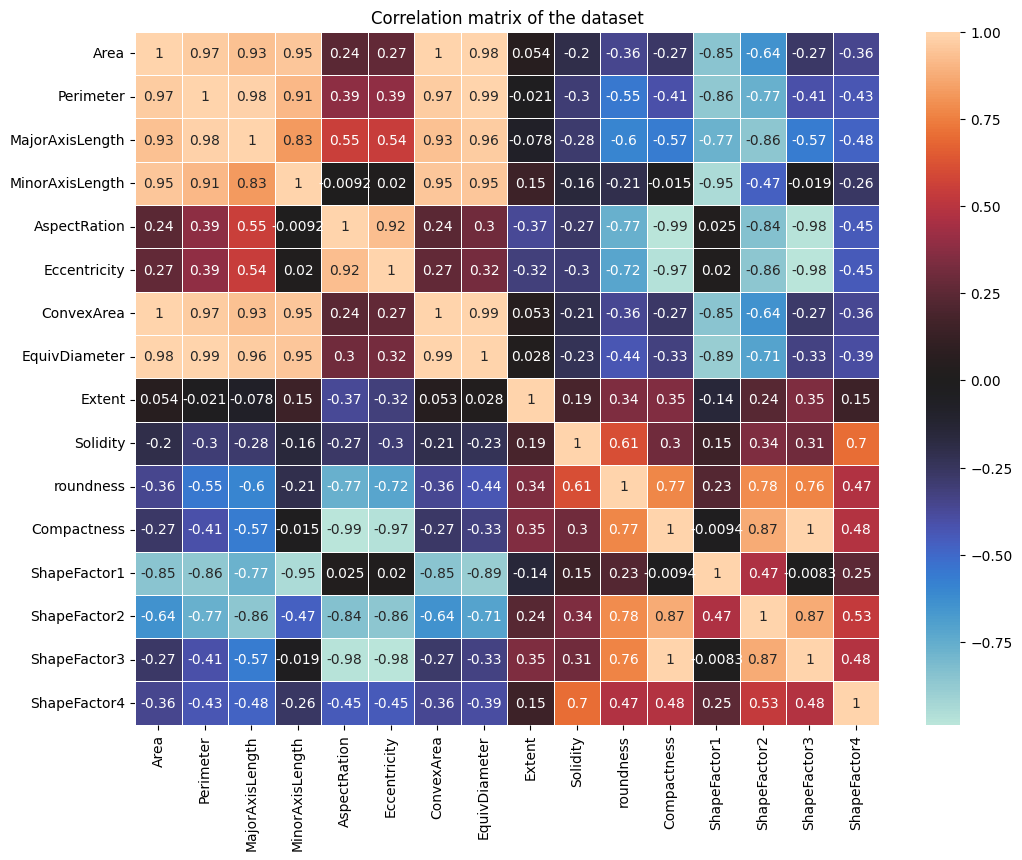

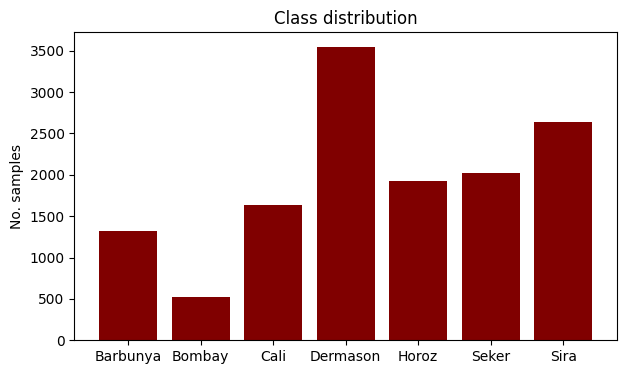

In [80]:
plot_correlation_matrix(df)
check_dataframe_balance(df)

In [81]:
def plot2d(X, y, mode=None, mode_str=None):
    plt_colors = ['tab:brown', 'tab:purple', 'tab:blue', 'tab:green', 'tab:olive', 'tab:orange', 'tab:red']
    
    transformer = None
    X_r = X
    
    if mode is not None:
        transformer = mode(n_components=2)
        X_r = transformer.fit_transform(X)

    assert X_r.shape[1] == 2, 'plot2d only works with 2-dimensional data'
    
    plt.rc('axes', axisbelow=True)
    plt.grid()
    
    barbunya = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 0], [X_r[i][1] for i in range(len(X_r)) if y[i] == 0], marker='.', color=plt_colors[0])
    bombay = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 1], [X_r[i][1] for i in range(len(X_r)) if y[i] == 1], marker='.', color=plt_colors[1])
    cali = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 2], [X_r[i][1] for i in range(len(X_r)) if y[i] == 2], marker='.', color=plt_colors[2])
    dermason = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 3], [X_r[i][1] for i in range(len(X_r)) if y[i] == 3], marker='.', color=plt_colors[3])
    horoz = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 4], [X_r[i][1] for i in range(len(X_r)) if y[i] == 4], marker='.', color=plt_colors[4])
    seker = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 5], [X_r[i][1] for i in range(len(X_r)) if y[i] == 5], marker='.', color=plt_colors[5])
    sira = plt.scatter([X_r[i][0] for i in range(len(X_r)) if y[i] == 6], [X_r[i][1] for i in range(len(X_r)) if y[i] == 6], marker='.', color=plt_colors[6])

    plt.legend((barbunya, bombay, cali, dermason, horoz, seker, sira),
               ('Barbunya', 'Bombay', 'Cali', 'Dermason', 'Horoz', 'Seker', 'Sira'),
               scatterpoints=1,
               loc='best',
               ncol=3,
               fontsize=8)
    
    if mode_str == "PCA":
        plt.title("Samples clustering visualised with PCA")
    else:
        plt.title("Samples clustering visualised with TSNE")
    plt.xlabel("x coord")
    plt.ylabel("y coord")

    plt.show()

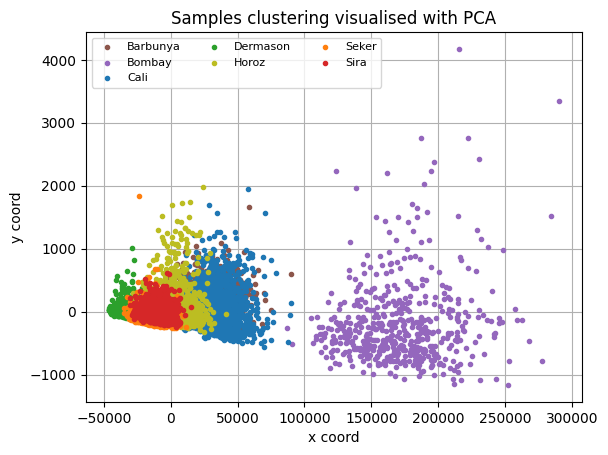

In [82]:
plot2d(np.asarray(X), np.asarray(y), PCA, 'PCA')

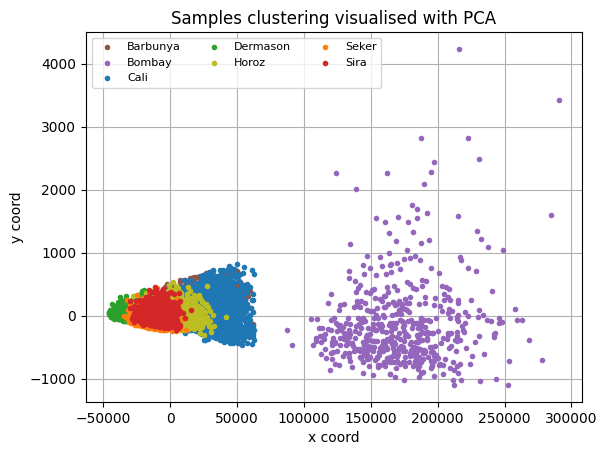

In [83]:
plot2d(np.asarray(X_cleaned), np.asarray(y_cleaned), PCA, 'PCA')

### EDA - PCA

[0.56504, 0.25919, 0.07044, 0.0528, 0.02962, 0.01233, 0.00682, 0.00312, 0.00049, 8e-05, 4e-05, 2e-05, 1e-05, 0.0, 0.0, 0.0]
[0.56504, 0.82423, 0.89467, 0.94747, 0.97709, 0.98942, 0.99624, 0.99936, 0.99985, 0.99994, 0.99998, 0.99999, 1.0, 1.0, 1.0, 1.0]


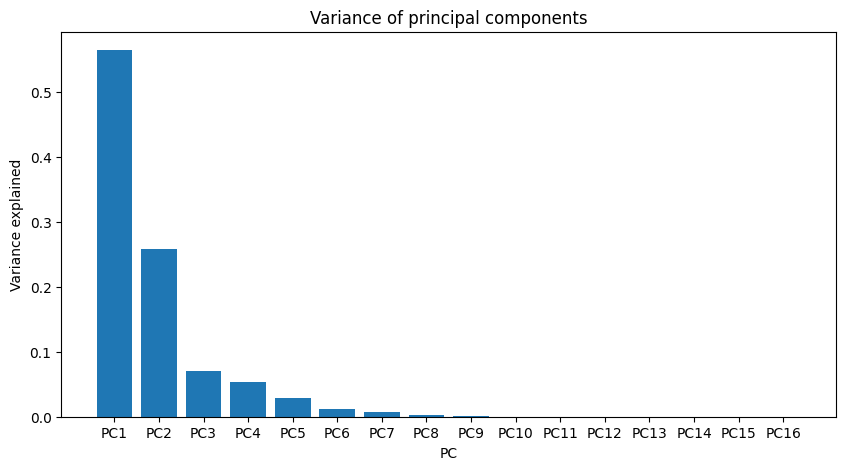

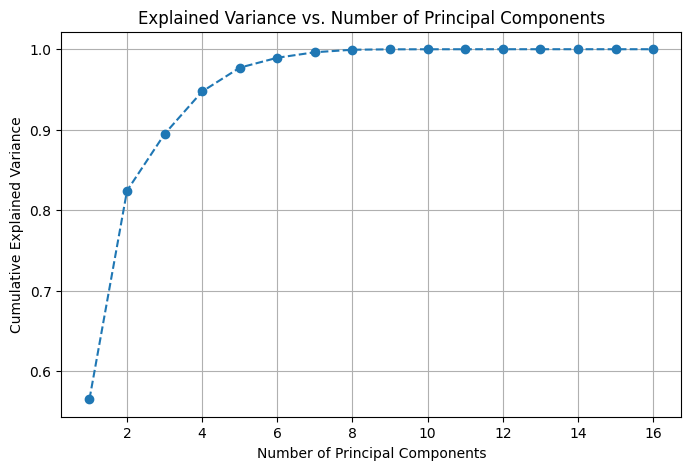

In [93]:
pca_model_eda = PCA()
pca_model_eda.fit(X_train_scaled)
print([round(pc_var, 5) for pc_var in pca_model_eda.explained_variance_ratio_])
cumulative_explained_variance = np.cumsum(pca_model_eda.explained_variance_ratio_) # Calculate the cumulative explained variance
print([round(pc_var, 5) for pc_var in cumulative_explained_variance])

# Determine the optimal number of components (e.g., 95% variance explained)
threshold = 0.95
optimal_components_count = np.argmax(cumulative_explained_variance >= threshold) + 1

pcs = [f'PC{i + 1}' for i in range(len(pca_model_eda.explained_variance_ratio_))]
variances = pca_model_eda.explained_variance_ratio_

# Plotting the explained variance graph
plt.figure(figsize = (10, 5))
plt.bar(pcs, variances)
plt.xlabel("PC")
plt.ylabel("Variance explained")
plt.title("Variance of principal components")
plt.show()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

### EDA - Lasso variable selection

In [33]:
Cs_ = np.logspace(-4, 4, 50)

lasso = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')
coefs = []

for C_ in Cs_:
    lasso.set_params(C=C_)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

coefs = np.asarray(coefs)

Text(0.5, 1.0, 'Model coefficients for different regularization factors')

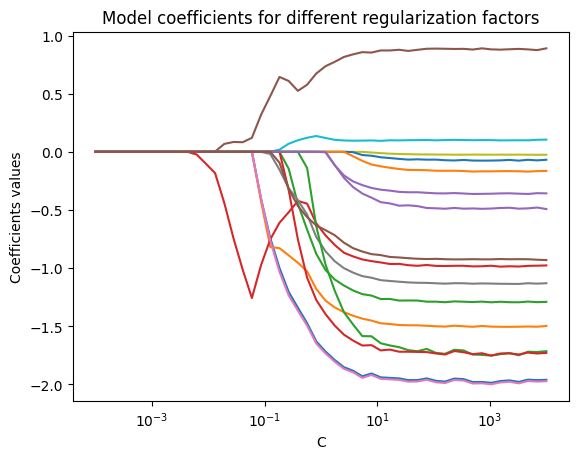

In [34]:
most_difficult_class = 6 # We want to plot the values of the coefficients of the model that predicted the largest amount of correct labels for the most difficult class

ax = plt.gca()
ax.plot(Cs_, coefs[:, most_difficult_class])
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('C')
plt.ylabel('Coefficients values')
plt.title('Model coefficients for different regularization factors')

### EDA - LDA

Explained variance: [0.56354064 0.19403136 0.10352105 0.0889238  0.03528948 0.01469365]
Cumulative variance: [0.56354064 0.75757201 0.86109306 0.95001686 0.98530635 1.        ]
The optimal number of components is: 4


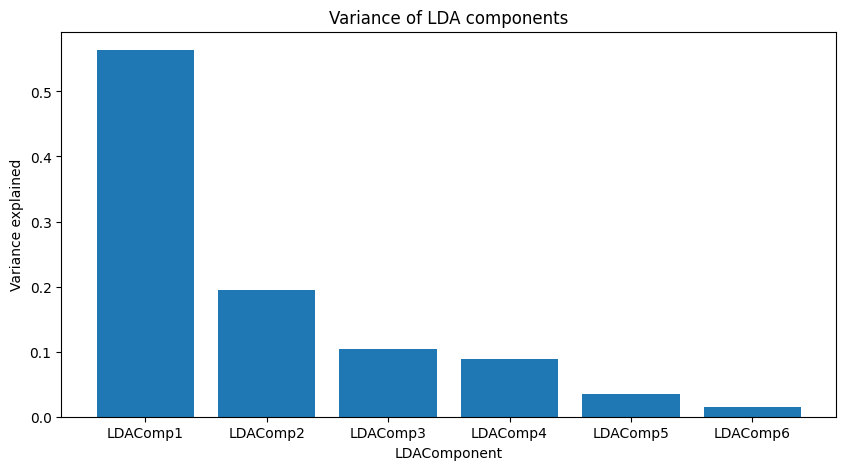

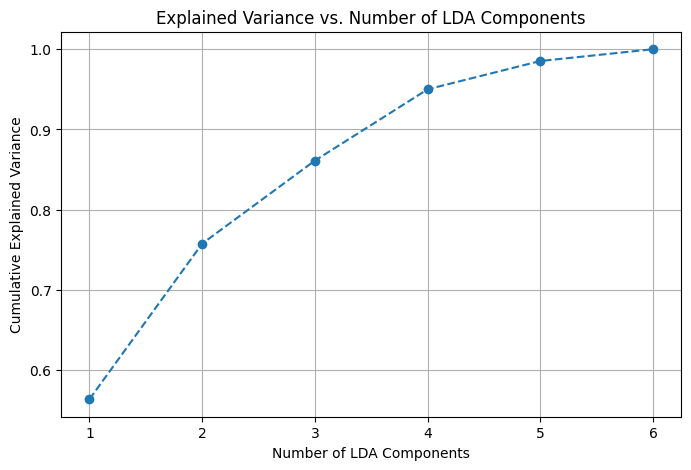

In [94]:
lda_model_eda = LinearDiscriminantAnalysis()
lda_model_eda.fit(X_train_scaled, y_train)
cummulative_exp_variance = np.cumsum(lda_model_eda.explained_variance_ratio_)
optimal_components = np.argmax(cummulative_exp_variance >= 0.95) + 1

print('Explained variance: ' + f'{lda_model_eda.explained_variance_ratio_}')
print('Cumulative variance: ' + f'{cummulative_exp_variance}')
print('The optimal number of components is: ' + f'{optimal_components}')

lda_comps = [f'LDAComp{i + 1}' for i in range(len(lda_model_eda.explained_variance_ratio_))]
variances = lda_model_eda.explained_variance_ratio_

# Plotting the explained variance graph
plt.figure(figsize = (10, 5))
plt.bar(lda_comps, variances)
plt.xlabel("LDAComponent")
plt.ylabel("Variance explained")
plt.title("Variance of LDA components")
plt.show()

# Plotting the cummulative variance graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cummulative_exp_variance) + 1), cummulative_exp_variance, marker='o', linestyle='--')
plt.xlabel('Number of LDA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of LDA Components')
plt.grid()
plt.show()

## Apply ML algorithms

### Logistic Regression

In [86]:
def get_optimum_parameters(params_grid, feat_train, label_train):
    grd = GridSearchCV(LogisticRegression(), params_grid, cv = 3, n_jobs = -1)

    start_time = time.time()
    grd.fit(feat_train, label_train)
    end_time = time.time()

    print('Time elapsed for grid search is: ', f'{end_time - start_time}', ' seconds')
    return grd.best_params_

params_grid = {
      'max_iter':[1000, 2000],
      'class_weight':[None, 'balanced'],
      'C':[1.0,0.1,10],
      'solver':['lbfgs', 'saga']
      #'penalty':['l2', None]
}

print('No dimensionality reduction: \n')
print(get_optimum_parameters(params_grid, X_train_scaled, y_train))
print()

print('PCA:\n')
print(get_optimum_parameters(params_grid, X_train_pca, y_train))
print()

print('Lasso:\n')
print(get_optimum_parameters(params_grid, X_train_selected, y_train))
print()

print('LDA:\n')
print(get_optimum_parameters(params_grid, X_train_lda, y_train))

PCA:

Time elapsed for grid search is:  12.797646045684814  seconds
{'C': 10, 'class_weight': None, 'max_iter': 1000, 'solver': 'lbfgs'}

LDA:

Time elapsed for grid search is:  21.32163143157959  seconds
{'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'solver': 'saga'}


              precision    recall  f1-score   support

           0       0.93      0.92      0.93       185
           1       1.00      1.00      1.00        79
           2       0.91      0.93      0.92       227
           3       0.92      0.93      0.93       527
           4       0.95      0.94      0.95       248
           5       0.95      0.93      0.94       287
           6       0.87      0.88      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



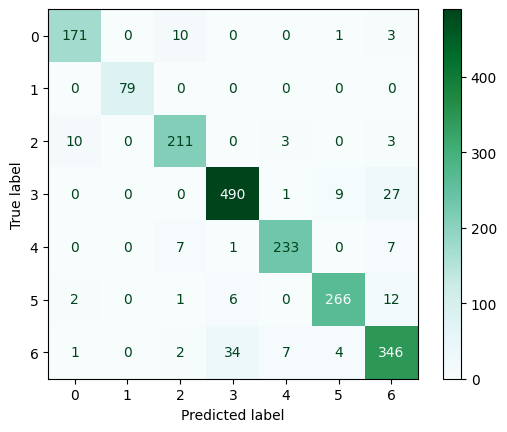

In [36]:
def show_confusion_matrix(y_true, y_pred, classif):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classif.classes_)
    disp.plot(cmap=plt.cm.BuGn)
    plt.show()


def training_model(features_train, features_test, labels_train, labels_test, iterations, C_reg, class_weight, solver):
    classifier = LogisticRegression(max_iter = iterations, C = C_reg, class_weight = class_weight, solver = solver, n_jobs = -1)
    classifier.fit(features_train, labels_train)

    predict = classifier.predict(features_test)
    clf_report = classification_report(labels_test, predict)

    print(clf_report)
    show_confusion_matrix(labels_test, predict, classifier)

In [ ]:
training_model(X_train_scaled, X_test_scaled, y_train, y_test, iterations = 1000, C_reg = 10, class_weight = None, solver = 'lbfgs')

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       185
           1       1.00      1.00      1.00        79
           2       0.93      0.94      0.93       227
           3       0.92      0.93      0.93       527
           4       0.94      0.96      0.95       248
           5       0.94      0.93      0.94       287
           6       0.87      0.86      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



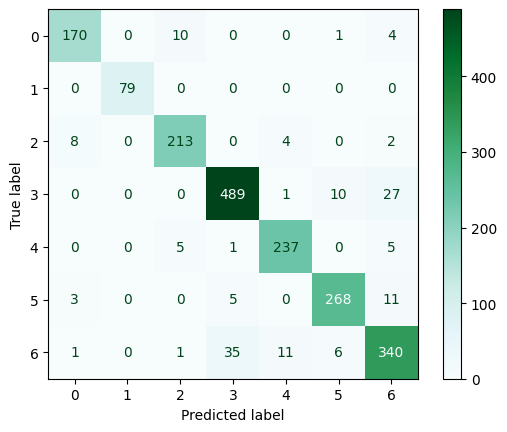

In [88]:
training_model(X_train_pca, X_test_pca, y_train, y_test, iterations = 1000, C_reg = 10, class_weight = None, solver = 'lbfgs')

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       185
           1       1.00      1.00      1.00        79
           2       0.93      0.93      0.93       227
           3       0.92      0.93      0.92       527
           4       0.94      0.96      0.95       248
           5       0.95      0.92      0.93       287
           6       0.87      0.88      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



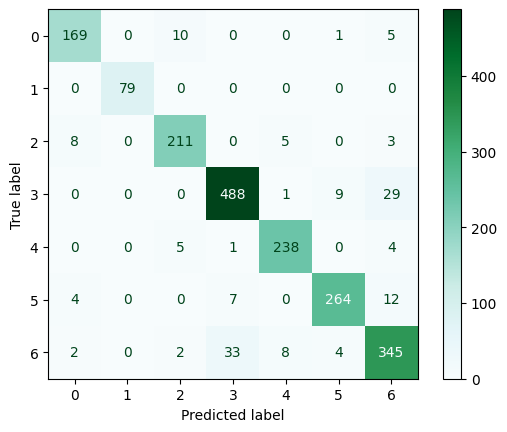

In [99]:
training_model(X_train_selected, X_test_selected, y_train, y_test, iterations = 1000, C_reg = 10, class_weight = None, solver = 'lbfgs')

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       185
           1       1.00      1.00      1.00        79
           2       0.93      0.93      0.93       227
           3       0.91      0.93      0.92       527
           4       0.95      0.95      0.95       248
           5       0.95      0.91      0.93       287
           6       0.86      0.87      0.86       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



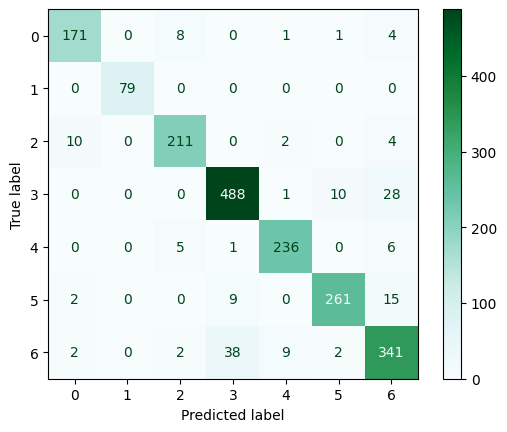

In [92]:
training_model(X_train_lda, X_test_lda, y_train, y_test, iterations = 1000, C_reg = 1.0, class_weight = None, solver = 'lbfgs')

### SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.7s
[CV] END .....................................C=0.1, gamma=1; total time=   1.7s
[CV] END .....................................C=0.1, gamma=1; total time=   1.7s
[CV] END .....................................C=0.1, gamma=1; total time=   1.6s
[CV] END .....................................C=0.1, gamma=1; total time=   1.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.6s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.0s
[CV] END ..................................C=0.1

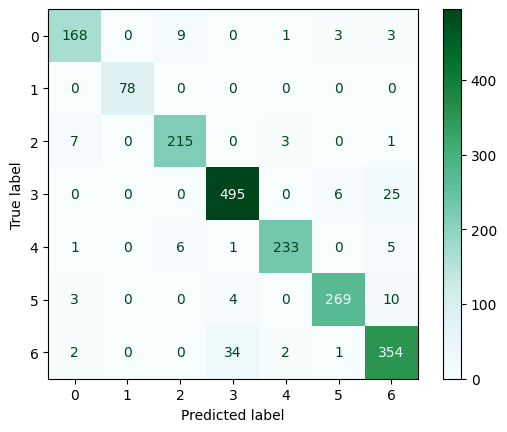

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       184
           1       1.00      1.00      1.00        78
           2       0.93      0.95      0.94       226
           3       0.93      0.94      0.93       526
           4       0.97      0.95      0.96       246
           5       0.96      0.94      0.95       286
           6       0.89      0.90      0.90       393

    accuracy                           0.93      1939
   macro avg       0.95      0.94      0.94      1939
weighted avg       0.93      0.93      0.93      1939


Testing dataset SVM:
Accuracy: 0.9337
Confusion Matrix:


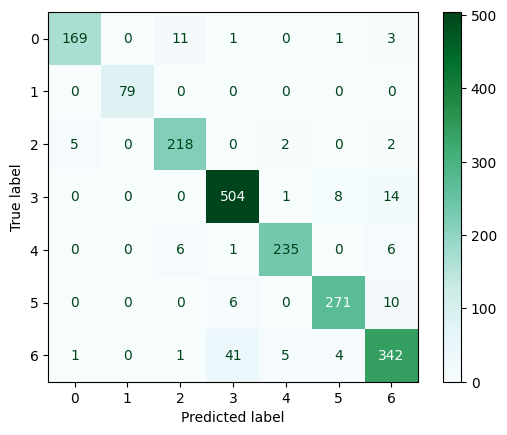

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       185
           1       1.00      1.00      1.00        79
           2       0.92      0.96      0.94       227
           3       0.91      0.96      0.93       527
           4       0.97      0.95      0.96       248
           5       0.95      0.94      0.95       287
           6       0.91      0.87      0.89       394

    accuracy                           0.93      1947
   macro avg       0.95      0.94      0.94      1947
weighted avg       0.93      0.93      0.93      1947


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.4s
[CV] END .....................................C=0.1, gamma=1; total time=   1.5s
[CV] END .....................................C=0.1, gamma=1; total time=   1.5s
[CV] END .....................................C=0.1, gamma=1; total time=  

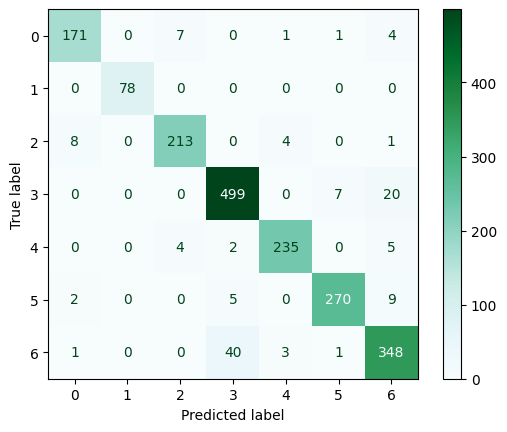

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       184
           1       1.00      1.00      1.00        78
           2       0.95      0.94      0.95       226
           3       0.91      0.95      0.93       526
           4       0.97      0.96      0.96       246
           5       0.97      0.94      0.96       286
           6       0.90      0.89      0.89       393

    accuracy                           0.94      1939
   macro avg       0.95      0.94      0.95      1939
weighted avg       0.94      0.94      0.94      1939


Testing dataset PCA + SVM:
Accuracy: 0.9266
Confusion Matrix:


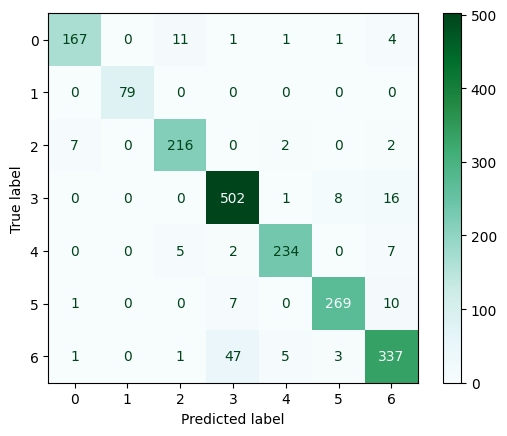

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       185
           1       1.00      1.00      1.00        79
           2       0.93      0.95      0.94       227
           3       0.90      0.95      0.92       527
           4       0.96      0.94      0.95       248
           5       0.96      0.94      0.95       287
           6       0.90      0.86      0.88       394

    accuracy                           0.93      1947
   macro avg       0.94      0.93      0.94      1947
weighted avg       0.93      0.93      0.93      1947


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.8s
[CV] END .....................................C=0.1, gamma=1; total time=   1.8s
[CV] END .....................................C=0.1, gamma=1; total time=   1.9s
[CV] END .....................................C=0.1, gamma=1; total time=  

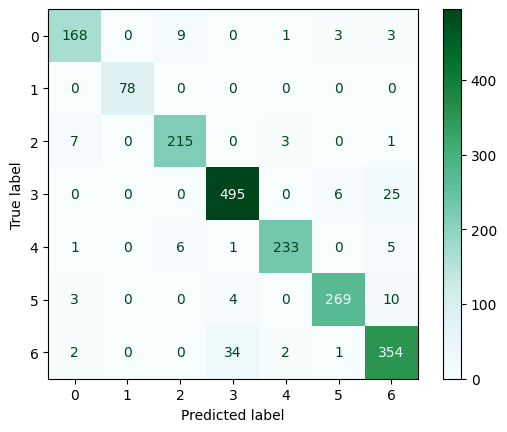

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       184
           1       1.00      1.00      1.00        78
           2       0.93      0.95      0.94       226
           3       0.93      0.94      0.93       526
           4       0.97      0.95      0.96       246
           5       0.96      0.94      0.95       286
           6       0.89      0.90      0.90       393

    accuracy                           0.93      1939
   macro avg       0.95      0.94      0.94      1939
weighted avg       0.93      0.93      0.93      1939


Testing dataset Lasso + SVM:
Accuracy: 0.9337
Confusion Matrix:


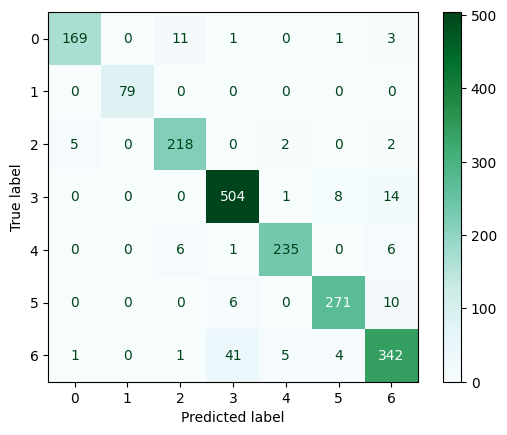

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       185
           1       1.00      1.00      1.00        79
           2       0.92      0.96      0.94       227
           3       0.91      0.96      0.93       527
           4       0.97      0.95      0.96       248
           5       0.95      0.94      0.95       287
           6       0.91      0.87      0.89       394

    accuracy                           0.93      1947
   macro avg       0.95      0.94      0.94      1947
weighted avg       0.93      0.93      0.93      1947


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.9s
[CV] END .....................................C=0.1, gamma=1; total time=   0.9s
[CV] END .....................................C=0.1, gamma=1; total time=  

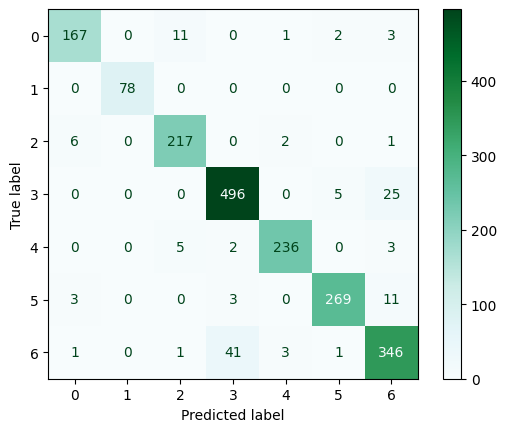

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       184
           1       1.00      1.00      1.00        78
           2       0.93      0.96      0.94       226
           3       0.92      0.94      0.93       526
           4       0.98      0.96      0.97       246
           5       0.97      0.94      0.96       286
           6       0.89      0.88      0.88       393

    accuracy                           0.93      1939
   macro avg       0.95      0.94      0.94      1939
weighted avg       0.93      0.93      0.93      1939


Testing dataset LDA + SVM:
Accuracy: 0.9214
Confusion Matrix:


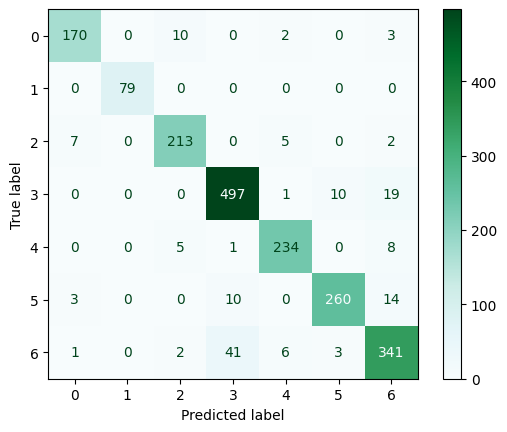

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       185
           1       1.00      1.00      1.00        79
           2       0.93      0.94      0.93       227
           3       0.91      0.94      0.92       527
           4       0.94      0.94      0.94       248
           5       0.95      0.91      0.93       287
           6       0.88      0.87      0.87       394

    accuracy                           0.92      1947
   macro avg       0.94      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947




In [110]:
def train_evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001]
    }
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
    grid.fit(X_train, y_train)
    print("Best Parameters:", grid.best_params_)
    best_model = grid.best_estimator_

    y_val_pred = best_model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    confusion_val = confusion_matrix(y_val, y_val_pred)
    report_val = classification_report(y_val, y_val_pred)

    y_test_pred = best_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    confusion_test = confusion_matrix(y_test, y_test_pred)
    report_test = classification_report(y_test, y_test_pred)

    return accuracy_val, confusion_val, report_val, accuracy_test, confusion_test, report_test

unique_labels = np.unique(df['Class'])

# Now you can use these unique labels to create custom_labels for the confusion matrix
custom_labels = unique_labels.tolist()

accuracy_val, confusion_val, report_val, accuracy_test, confusion_test, report_test = train_evaluate_svm(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
print(" Validation dataset SVM:")
print(f"Accuracy: {accuracy_val:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_val, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_val)
print()

print("Testing dataset SVM:")
print(f"Accuracy: {accuracy_test:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_test, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_test)
print()



# PCA + SVM
accuracy_val_pca, confusion_val_pca, report_val_pca, accuracy_test_pca, confusion_test_pca, report_test_pca = train_evaluate_svm(X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test)
print("Validation dataset PCA + SVM:")
print(f"Accuracy: {accuracy_val_pca:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_val_pca, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_val_pca)
print()

print("Testing dataset PCA + SVM:")
print(f"Accuracy: {accuracy_test_pca:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_test_pca, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_test_pca)
print()

accuracy_val_lasso, confusion_val_lasso, report_val_lasso, accuracy_test_lasso, confusion_test_lasso, report_test_lasso = train_evaluate_svm(X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test)
print("Validation dataset Lasso + SVM:")
print(f"Accuracy: {accuracy_val_lasso:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_val_lasso, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_val_lasso)
print()

print("Testing dataset Lasso + SVM:")
print(f"Accuracy: {accuracy_test_lasso:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_test_lasso, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_test_lasso)
print()

# LDA + SVM
accuracy_val_lda, confusion_val_lda, report_val_lda, accuracy_test_lda, confusion_test_lda, report_test_lda = train_evaluate_svm(X_train_lda, y_train, X_val_lda, y_val, X_test_lda, y_test)
print("Validation dataset LDA + SVM:")
print(f"Accuracy: {accuracy_val_lda:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_val_lda, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_val_lda)
print()

print("Testing dataset LDA + SVM:")
print(f"Accuracy: {accuracy_test_lda:.4f}")
print("Confusion Matrix:")
mat_confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_test_lda, display_labels=custom_labels)

# Plot the confusion matrix
mat_confusion_display.plot(cmap=plt.cm.BuGn)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
print("Classification Report:")
print(report_test_lda)
print()


### Random Forest

In [42]:
def draw_conf_matrix(cm):
    cm_disp = ConfusionMatrixDisplay(cm)
    cm_disp.plot(cmap=plt.cm.BuGn)
    plt.show()

In [45]:
def get_optimal_model_hyperparams(X_train, y_train):
    grid = {'n_estimators': [175],
            'max_features': [None],
            'max_depth': [20],
            'min_samples_split': [10],
            'min_samples_leaf': [2],
            'class_weight': ['balanced']}
    
    grid_search = GridSearchCV(RandomForestClassifier(), grid, scoring='f1_macro', cv=3, verbose=2)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [46]:
def model_predict(X_train, X_val, X_test, y_train, y_val, y_test, model):
    y_train_pred, y_val_pred, y_test_pred = model.predict(X_train), model.predict(X_val), model.predict(X_test)

    train_rep = classification_report(y_train, y_train_pred, labels=np.unique(y_train))
    val_rep = classification_report(y_val, y_val_pred, labels=np.unique(y_val))
    test_rep = classification_report(y_test, y_test_pred, labels=np.unique(y_test))

    print('Types of labels in train/val/test, true and predicted:')
    print(np.unique(y_train), np.unique(y_train_pred))
    print(np.unique(y_val), np.unique(y_val_pred))
    print(np.unique(y_test), np.unique(y_test_pred))
    print()

    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    train_res = (train_rep, train_cm)
    val_res = (val_rep, val_cm)
    test_res = (test_rep, test_cm)

    return train_res, val_res, test_res

In [139]:
start = time.time()
grid_search_1 = get_optimal_model_hyperparams(X_train, y_train)
end = time.time()
print(f'\nElapsed time for hyperparameter search: {round(end - start, 5)}\n')
print(f'Optimal model hyperparameters: {grid_search_1.best_params_}')
model = grid_search_1.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=  10.6s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=  10.8s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=  10.6s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_lea

[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=  12.3s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=  13.6s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=  13.1s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.8s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=175; total time=  11.9s

Types of labels in train/val/test, true and predicted:
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]

No dim. reduction


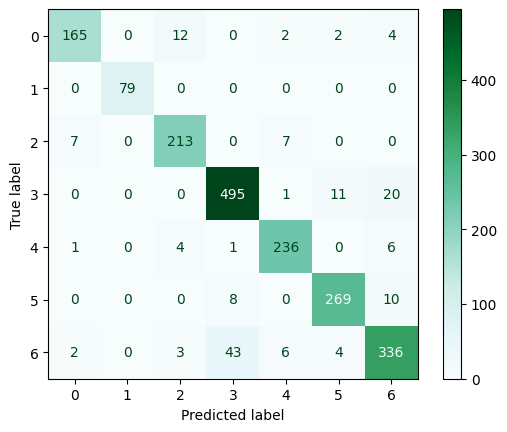

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       185
           1       1.00      1.00      1.00        79
           2       0.92      0.94      0.93       227
           3       0.90      0.94      0.92       527
           4       0.94      0.95      0.94       248
           5       0.94      0.94      0.94       287
           6       0.89      0.85      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



In [140]:
train_res, val_res, test_res = model_predict(X_train, X_val, X_test, y_train, y_val, y_test, model)
print(f'No dim. reduction')
draw_conf_matrix(test_res[1])
print('Classification report:')
print(test_res[0])

In [141]:
start = time.time()
grid_search_2 = get_optimal_model_hyperparams(X_train_pca, y_train)
end = time.time()
print(f'\nElapsed time for hyperparameter search: {round(end - start, 5)}\n')
print(f'Optimal model hyperparameters: {grid_search_2.best_params_}')
model = grid_search_2.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.4s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.3s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.4s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_lea

[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.7s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.5s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.7s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=175; total time=   3.7s

Types of labels in train/val/test, true and predicted:
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]

PCA with 5 components


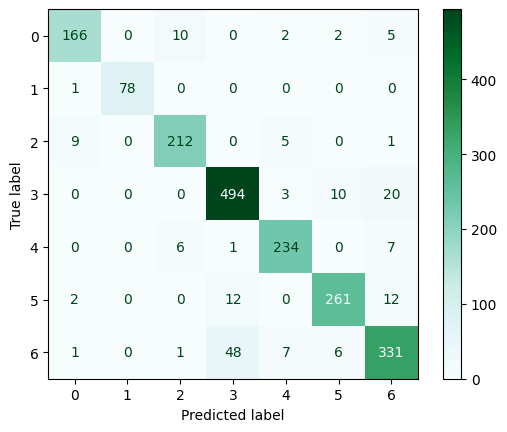

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       185
           1       1.00      0.99      0.99        79
           2       0.93      0.93      0.93       227
           3       0.89      0.94      0.91       527
           4       0.93      0.94      0.94       248
           5       0.94      0.91      0.92       287
           6       0.88      0.84      0.86       394

    accuracy                           0.91      1947
   macro avg       0.93      0.92      0.92      1947
weighted avg       0.91      0.91      0.91      1947



In [142]:
train_res, val_res, test_res = model_predict(X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test, model)
print(f'PCA with {pca_model.n_components_} components')
draw_conf_matrix(test_res[1])
print('Classification report:')
print(test_res[0])

In [47]:
start = time.time()
grid_search_3 = get_optimal_model_hyperparams(X_train_selected, y_train)
end = time.time()
print(f'\nElapsed time for hyperparameter search: {round(end - start, 5)}\n')
print(f'Optimal model hyperparameters: {grid_search_3.best_params_}')
model = grid_search_3.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=175; total time=   8.3s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=175; total time=   8.1s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=175; total time=   8.2s

Elapsed time for hyperparameter search: 37.26449

Optimal model hyperparameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 175}


In [48]:
selected_features

array([ 0,  1,  2,  3,  5,  6,  7,  9, 12, 13, 15])

Types of labels in train/val/test, true and predicted:
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]

With Lasso variable selection


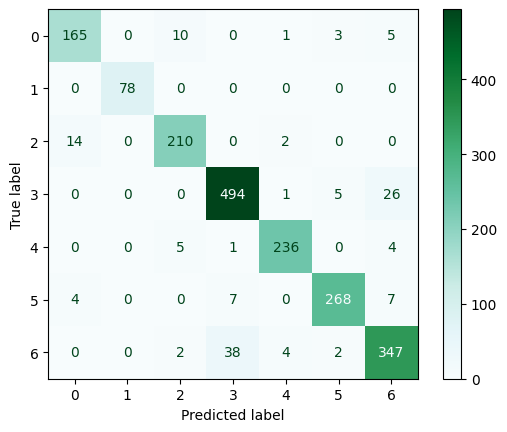

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       185
           1       1.00      1.00      1.00        79
           2       0.90      0.94      0.92       227
           3       0.92      0.94      0.93       527
           4       0.94      0.94      0.94       248
           5       0.93      0.93      0.93       287
           6       0.87      0.86      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



In [49]:
train_res, val_res, test_res = model_predict(X_train_selected, X_val_selected, X_test_selected, y_train, y_val, y_test, model)
print(f'With Lasso variable selection')
draw_conf_matrix(val_res[1])
print('Classification report:')
print(test_res[0])

In [149]:
start = time.time()
grid_search_4 = get_optimal_model_hyperparams(X_train_lda, y_train)
end = time.time()
print(f'\nElapsed time for hyperparameter search: {round(end - start, 5)}\n')
print(f'Optimal model hyperparameters: {grid_search_4.best_params_}')
model = grid_search_4.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.1s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   2.8s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.3s
[CV] END class_weight=balanced, max_depth=10, max_features=None, min_samples_lea

[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.4s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.6s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   3.8s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=175; total time=   4.2s

Types of labels in train/val/test, true and predicted:
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]
[0 1 2 3 4 5 6] [0 1 2 3 4 5 6]

LDA with 4 discriminants


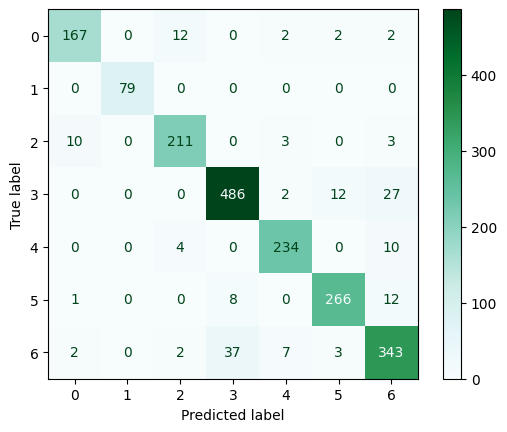

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       185
           1       1.00      1.00      1.00        79
           2       0.92      0.93      0.93       227
           3       0.92      0.92      0.92       527
           4       0.94      0.94      0.94       248
           5       0.94      0.93      0.93       287
           6       0.86      0.87      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



In [150]:
train_res, val_res, test_res = model_predict(X_train_lda, X_val_lda, X_test_lda, y_train, y_val, y_test, model)
print(f'LDA with {lda_model.n_components} discriminants')
draw_conf_matrix(test_res[1])
print('Classification report:')
print(test_res[0])

### Naive Bayes

In [ ]:
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.BuGn)
    plt.show()

def training_model(features_train, features_test, labels_train, labels_test):
    classifier = GaussianNB()
    classifier.fit(features_train, labels_train)

    predict = classifier.predict(features_test)

    clf_report = classification_report(labels_test, predict)
    print(clf_report)

    show_confusion_matrix(labels_test, predict)

In [ ]:
training_model(X_train_scaled, X_test_scaled, y_train, y_test)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       185
           1       1.00      1.00      1.00        79
           2       0.91      0.93      0.92       227
           3       0.87      0.89      0.88       527
           4       0.89      0.96      0.92       248
           5       0.94      0.89      0.91       287
           6       0.83      0.78      0.80       394

    accuracy                           0.89      1947
   macro avg       0.90      0.91      0.90      1947
weighted avg       0.89      0.89      0.89      1947



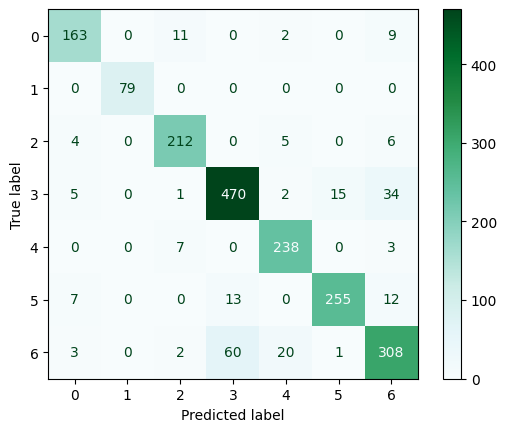

In [120]:
training_model(X_train_pca, X_test_pca, y_train, y_test)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       185
           1       1.00      1.00      1.00        79
           2       0.89      0.91      0.90       227
           3       0.93      0.90      0.92       527
           4       0.92      0.96      0.94       248
           5       0.94      0.92      0.93       287
           6       0.84      0.87      0.85       394

    accuracy                           0.90      1947
   macro avg       0.91      0.91      0.91      1947
weighted avg       0.90      0.90      0.90      1947



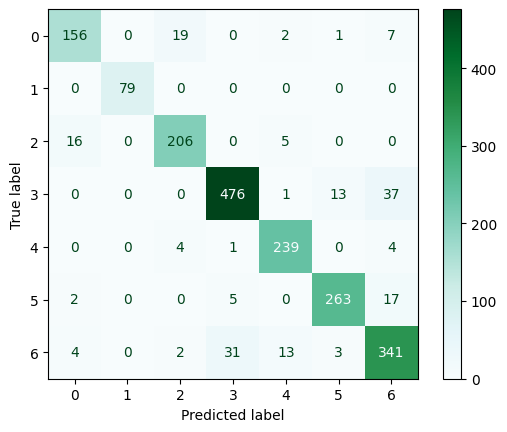

In [121]:
training_model(X_train_selected, X_test_selected, y_train, y_test)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       185
           1       1.00      1.00      1.00        79
           2       0.87      0.95      0.91       227
           3       0.90      0.91      0.91       527
           4       0.95      0.96      0.95       248
           5       0.94      0.91      0.93       287
           6       0.87      0.85      0.86       394

    accuracy                           0.91      1947
   macro avg       0.92      0.92      0.92      1947
weighted avg       0.91      0.91      0.91      1947



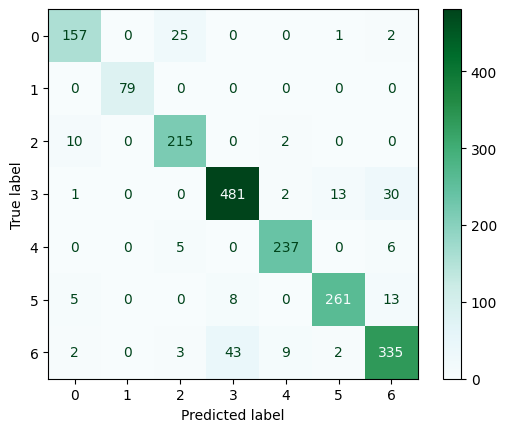

In [122]:
training_model(X_train_lda, X_test_lda, y_train, y_test)

### KNN

In [126]:
def get_optimum_parameters(params_grid, feat_train, label_train):
    grd = GridSearchCV(KNeighborsClassifier(), params_grid, cv=3, n_jobs=-1)

    start_time = time.time()
    grd.fit(feat_train, label_train)
    end_time = time.time()

    print('Time elapsed for grid search is:', f'{end_time - start_time}', ' seconds')
    return grd.best_params_

params_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print('No dimensionality reduction: \n')
print(get_optimum_parameters(params_grid, X_train_scaled, y_train))
print()

print('PCA:\n')
print(get_optimum_parameters(params_grid, X_train_pca, y_train))
print()

print('Lasso:\n')
print(get_optimum_parameters(params_grid, X_train_selected, y_train))
print()

print('LDA:\n')
print(get_optimum_parameters(params_grid, X_train_lda, y_train))

No dimensionality reduction: 

Time elapsed for grid search is: 5.244561433792114  seconds
{'metric': 'euclidean', 'n_neighbors': 15}

PCA:

Time elapsed for grid search is: 4.991523742675781  seconds
{'metric': 'manhattan', 'n_neighbors': 21}

Lasso:

Time elapsed for grid search is: 6.818824768066406  seconds
{'metric': 'euclidean', 'n_neighbors': 15}

LDA:

Time elapsed for grid search is: 5.238367557525635  seconds
{'metric': 'euclidean', 'n_neighbors': 21}


In [127]:
def show_confusion_matrix(y_true, y_pred, classif):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.BuGn)
    plt.show()

def training_model(features_train, features_test, labels_train, labels_test, n_neighbors, metric):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    classifier.fit(features_train, labels_train)

    predict = classifier.predict(features_test)
    clf_report = classification_report(labels_test, predict)

    print(clf_report)
    show_confusion_matrix(labels_test, predict, classifier)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       185
           1       1.00      1.00      1.00        79
           2       0.92      0.96      0.94       227
           3       0.92      0.94      0.93       527
           4       0.96      0.95      0.96       248
           5       0.95      0.91      0.93       287
           6       0.88      0.89      0.88       394

    accuracy                           0.93      1947
   macro avg       0.94      0.94      0.94      1947
weighted avg       0.93      0.93      0.93      1947



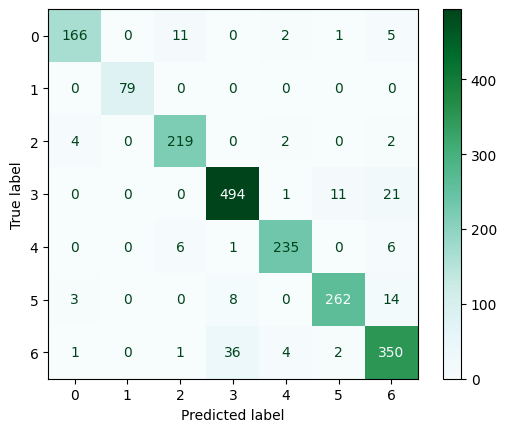

In [128]:
training_model(X_train_scaled, X_test_scaled, y_train, y_test, n_neighbors=15, metric='euclidean')

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       185
           1       1.00      1.00      1.00        79
           2       0.90      0.96      0.93       227
           3       0.91      0.93      0.92       527
           4       0.96      0.94      0.95       248
           5       0.95      0.92      0.93       287
           6       0.87      0.88      0.87       394

    accuracy                           0.92      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.92      0.92      1947



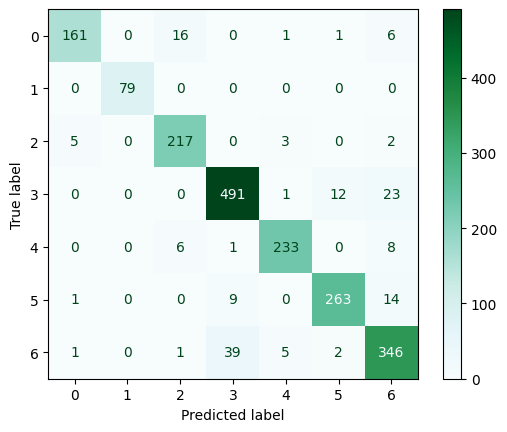

In [129]:
training_model(X_train_pca, X_test_pca, y_train, y_test, n_neighbors=15, metric='euclidean')

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       185
           1       1.00      1.00      1.00        79
           2       0.92      0.96      0.94       227
           3       0.92      0.94      0.93       527
           4       0.96      0.95      0.96       248
           5       0.95      0.91      0.93       287
           6       0.88      0.89      0.88       394

    accuracy                           0.93      1947
   macro avg       0.94      0.94      0.94      1947
weighted avg       0.93      0.93      0.93      1947



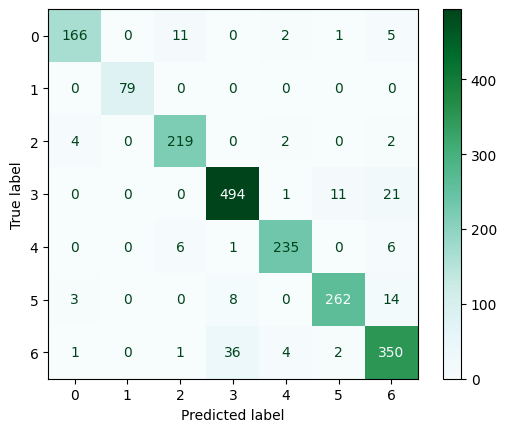

In [130]:
training_model(X_train_selected, X_test_selected, y_train, y_test, n_neighbors=15, metric='euclidean')

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       185
           1       1.00      1.00      1.00        79
           2       0.92      0.96      0.94       227
           3       0.89      0.93      0.91       527
           4       0.95      0.94      0.95       248
           5       0.95      0.91      0.93       287
           6       0.86      0.85      0.85       394

    accuracy                           0.91      1947
   macro avg       0.93      0.93      0.93      1947
weighted avg       0.92      0.91      0.91      1947



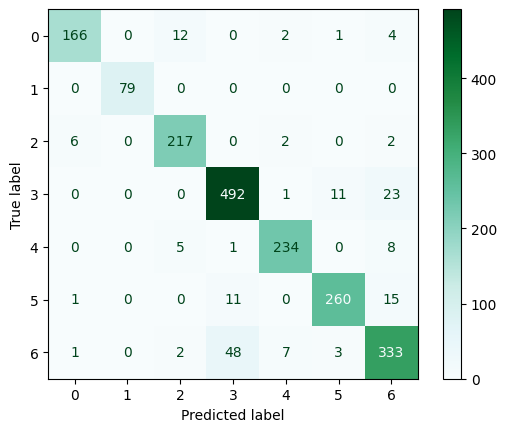

In [131]:
training_model(X_train_lda, X_test_lda, y_train, y_test, n_neighbors=15, metric='euclidean')